In [1]:
#Bibliotecas usadas no projeto
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import ast


from scipy.spatial import distance 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean,correlation,chebyshev
from scipy.stats import pearsonr

* Utilizando a métrica NSE, separamos as pessoas que fizeram ENEM em 8 grupos socioeconômicos distintos.
* Calculamos a similaridade entre as distribuições de resposta das LLMs e dos humanos de cada grupo.
* Problemas: análise rasa; as similaridades observadas podem ser uma consequência da probabilidade de acerto dos modelos.

In [2]:
models = pd.read_csv("data/models_cleanned.csv")
models.head()

,index,CO_ITEM,SG_AREA,TP_LINGUA,IN_ITEM_ABAN,model,is_human,model_probs,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,answer,correct_prob
0,0,140567,LC,spanish,0.0,GPT4,False,[9.99700057e-01 9.99700145e-05 9.99700145e-05 ...,1.95054,-0.11616,0.18874,B,9.997001e-05
1,1,140767,LC,english,0.0,GPT4,False,[1.85501901e-07 9.99799572e-01 9.99800083e-05 ...,4.34313,0.36871,0.44865,B,9.997996e-01
2,2,140731,LC,english,0.0,GPT4,False,[9.98706549e-09 1.07985925e-08 8.40995232e-09 ...,2.88489,0.49591,0.18224,D,9.999000e-01
3,3,140527,LC,spanish,0.0,GPT4,False,[9.99699956e-01 1.33598669e-07 9.99700367e-05 ...,1.12895,-0.11509,0.20583,A,9.997000e-01
4,4,118252,LC,spanish,0.0,GPT4,False,[7.08189002e-09 9.99900010e-05 1.60506752e-09 ...,1.93731,0.91995,0.14292,A,7.081890e-09


In [3]:
models['model_probs'] = models['model_probs'].apply(lambda x: ",".join(x.split()).replace(",]", "]").replace("[,", "["))
models["model_probs"] = models["model_probs"].apply(ast.literal_eval)
models["model_probs"] = models["model_probs"].apply(np.array)

In [4]:
human = models[models["is_human"] == True]
llm = models[models["is_human"] == False]

<Axes: xlabel='correct_prob', ylabel='model'>

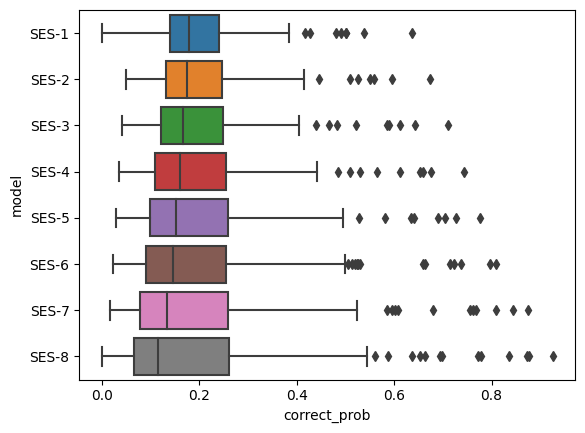

In [5]:
sns.boxplot(data=human,x="correct_prob",y="model")

<Axes: xlabel='correct_prob', ylabel='model'>

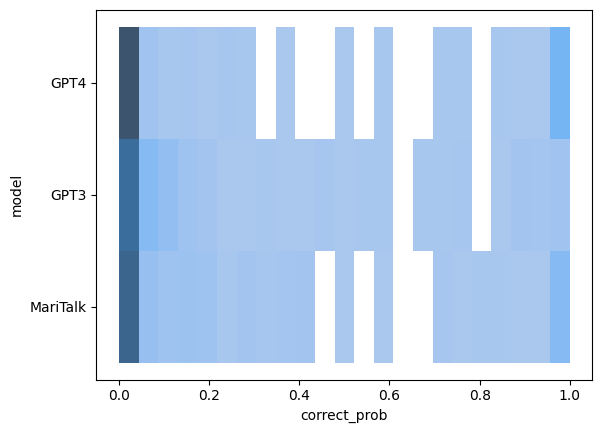

In [6]:
sns.histplot(data=llm,x="correct_prob",y="model")

In [7]:
from scipy.stats import entropy
models["entropy"] = models["model_probs"].apply(entropy)

In [8]:
def calculate_distance(row,df):
    p = row["model_probs"].astype(np.float64)
    q = df.loc[df['CO_ITEM'] == row['CO_ITEM'], "model_probs"].values[0]
    return distance.jensenshannon(p, q,base=2)

for i in range(1,9):
    SES = models[models["model"] == f"SES-{i}"]
    models[f'distance_to_SES-{i}'] = models.apply(lambda x : calculate_distance(x,SES), axis=1)

In [9]:
gpt = models[models["model"] == "GPT4"]

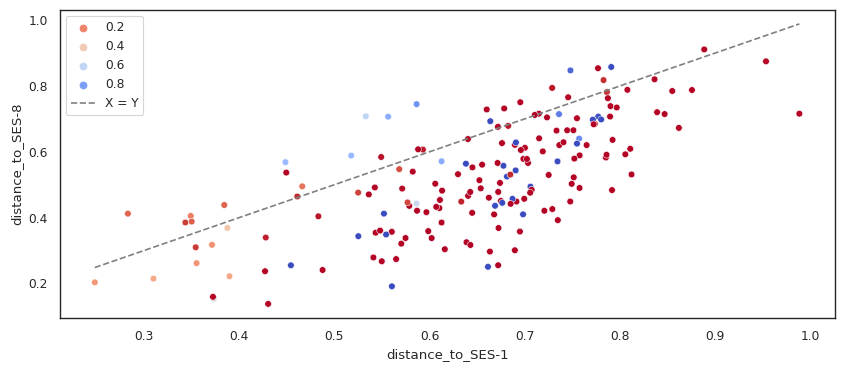

In [10]:
sns.set_style("white")
sns.set_context("paper")
plt.figure(figsize=(10, 4))
sns.scatterplot(data=gpt, x="distance_to_SES-1", y="distance_to_SES-8", hue="correct_prob", palette="coolwarm_r")
# Draw the line x=y
plt.plot([min(gpt['distance_to_SES-1']), max(gpt['distance_to_SES-1'])], 
         [min(gpt['distance_to_SES-1']), max(gpt['distance_to_SES-1'])], 
         linestyle='--', color='gray',label="X = Y")

plt.legend()
plt.show()

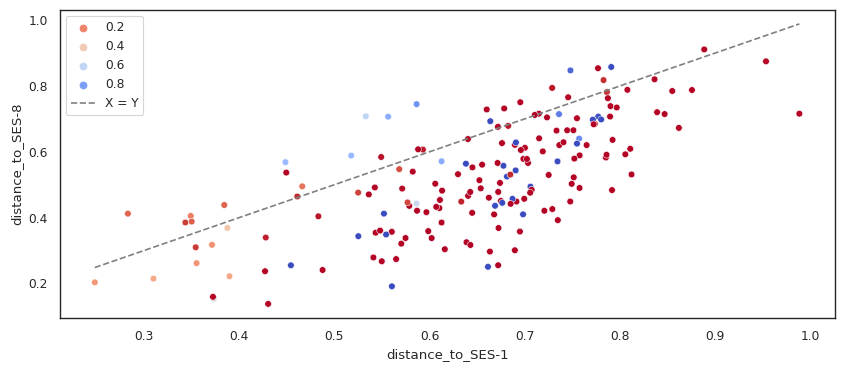

In [11]:
sns.set_style("white")
sns.set_context("paper")
plt.figure(figsize=(10, 4))
sns.scatterplot(data=gpt, x="distance_to_SES-1", y="distance_to_SES-8", hue="correct_prob", palette="coolwarm_r")
# Draw the line x=y
plt.plot([min(gpt['distance_to_SES-1']), max(gpt['distance_to_SES-1'])], 
         [min(gpt['distance_to_SES-1']), max(gpt['distance_to_SES-1'])], 
         linestyle='--', color='gray',label="X = Y")

plt.legend()
plt.show()

<Axes: >

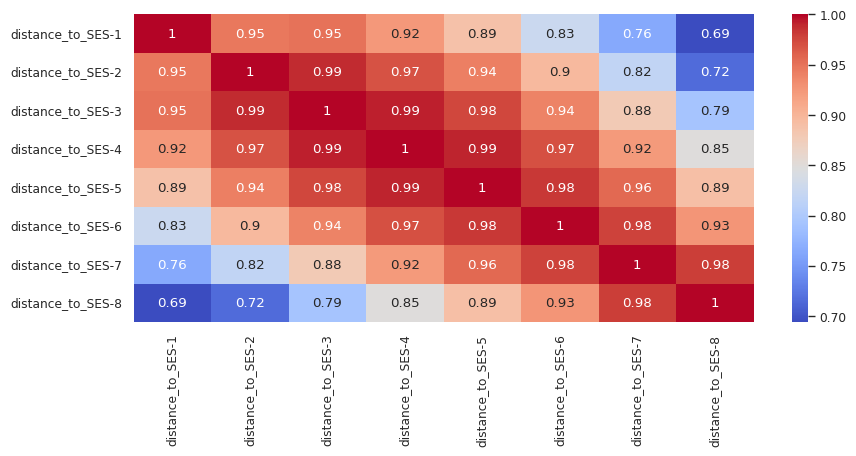

In [12]:
cols = [f'distance_to_SES-{i}' for i in range(1,9)]
sns.set_style("white")
sns.set_context("paper")
plt.figure(figsize=(10, 4))

correlation_matrix = gpt[cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


<Figure size 1000x400 with 0 Axes>

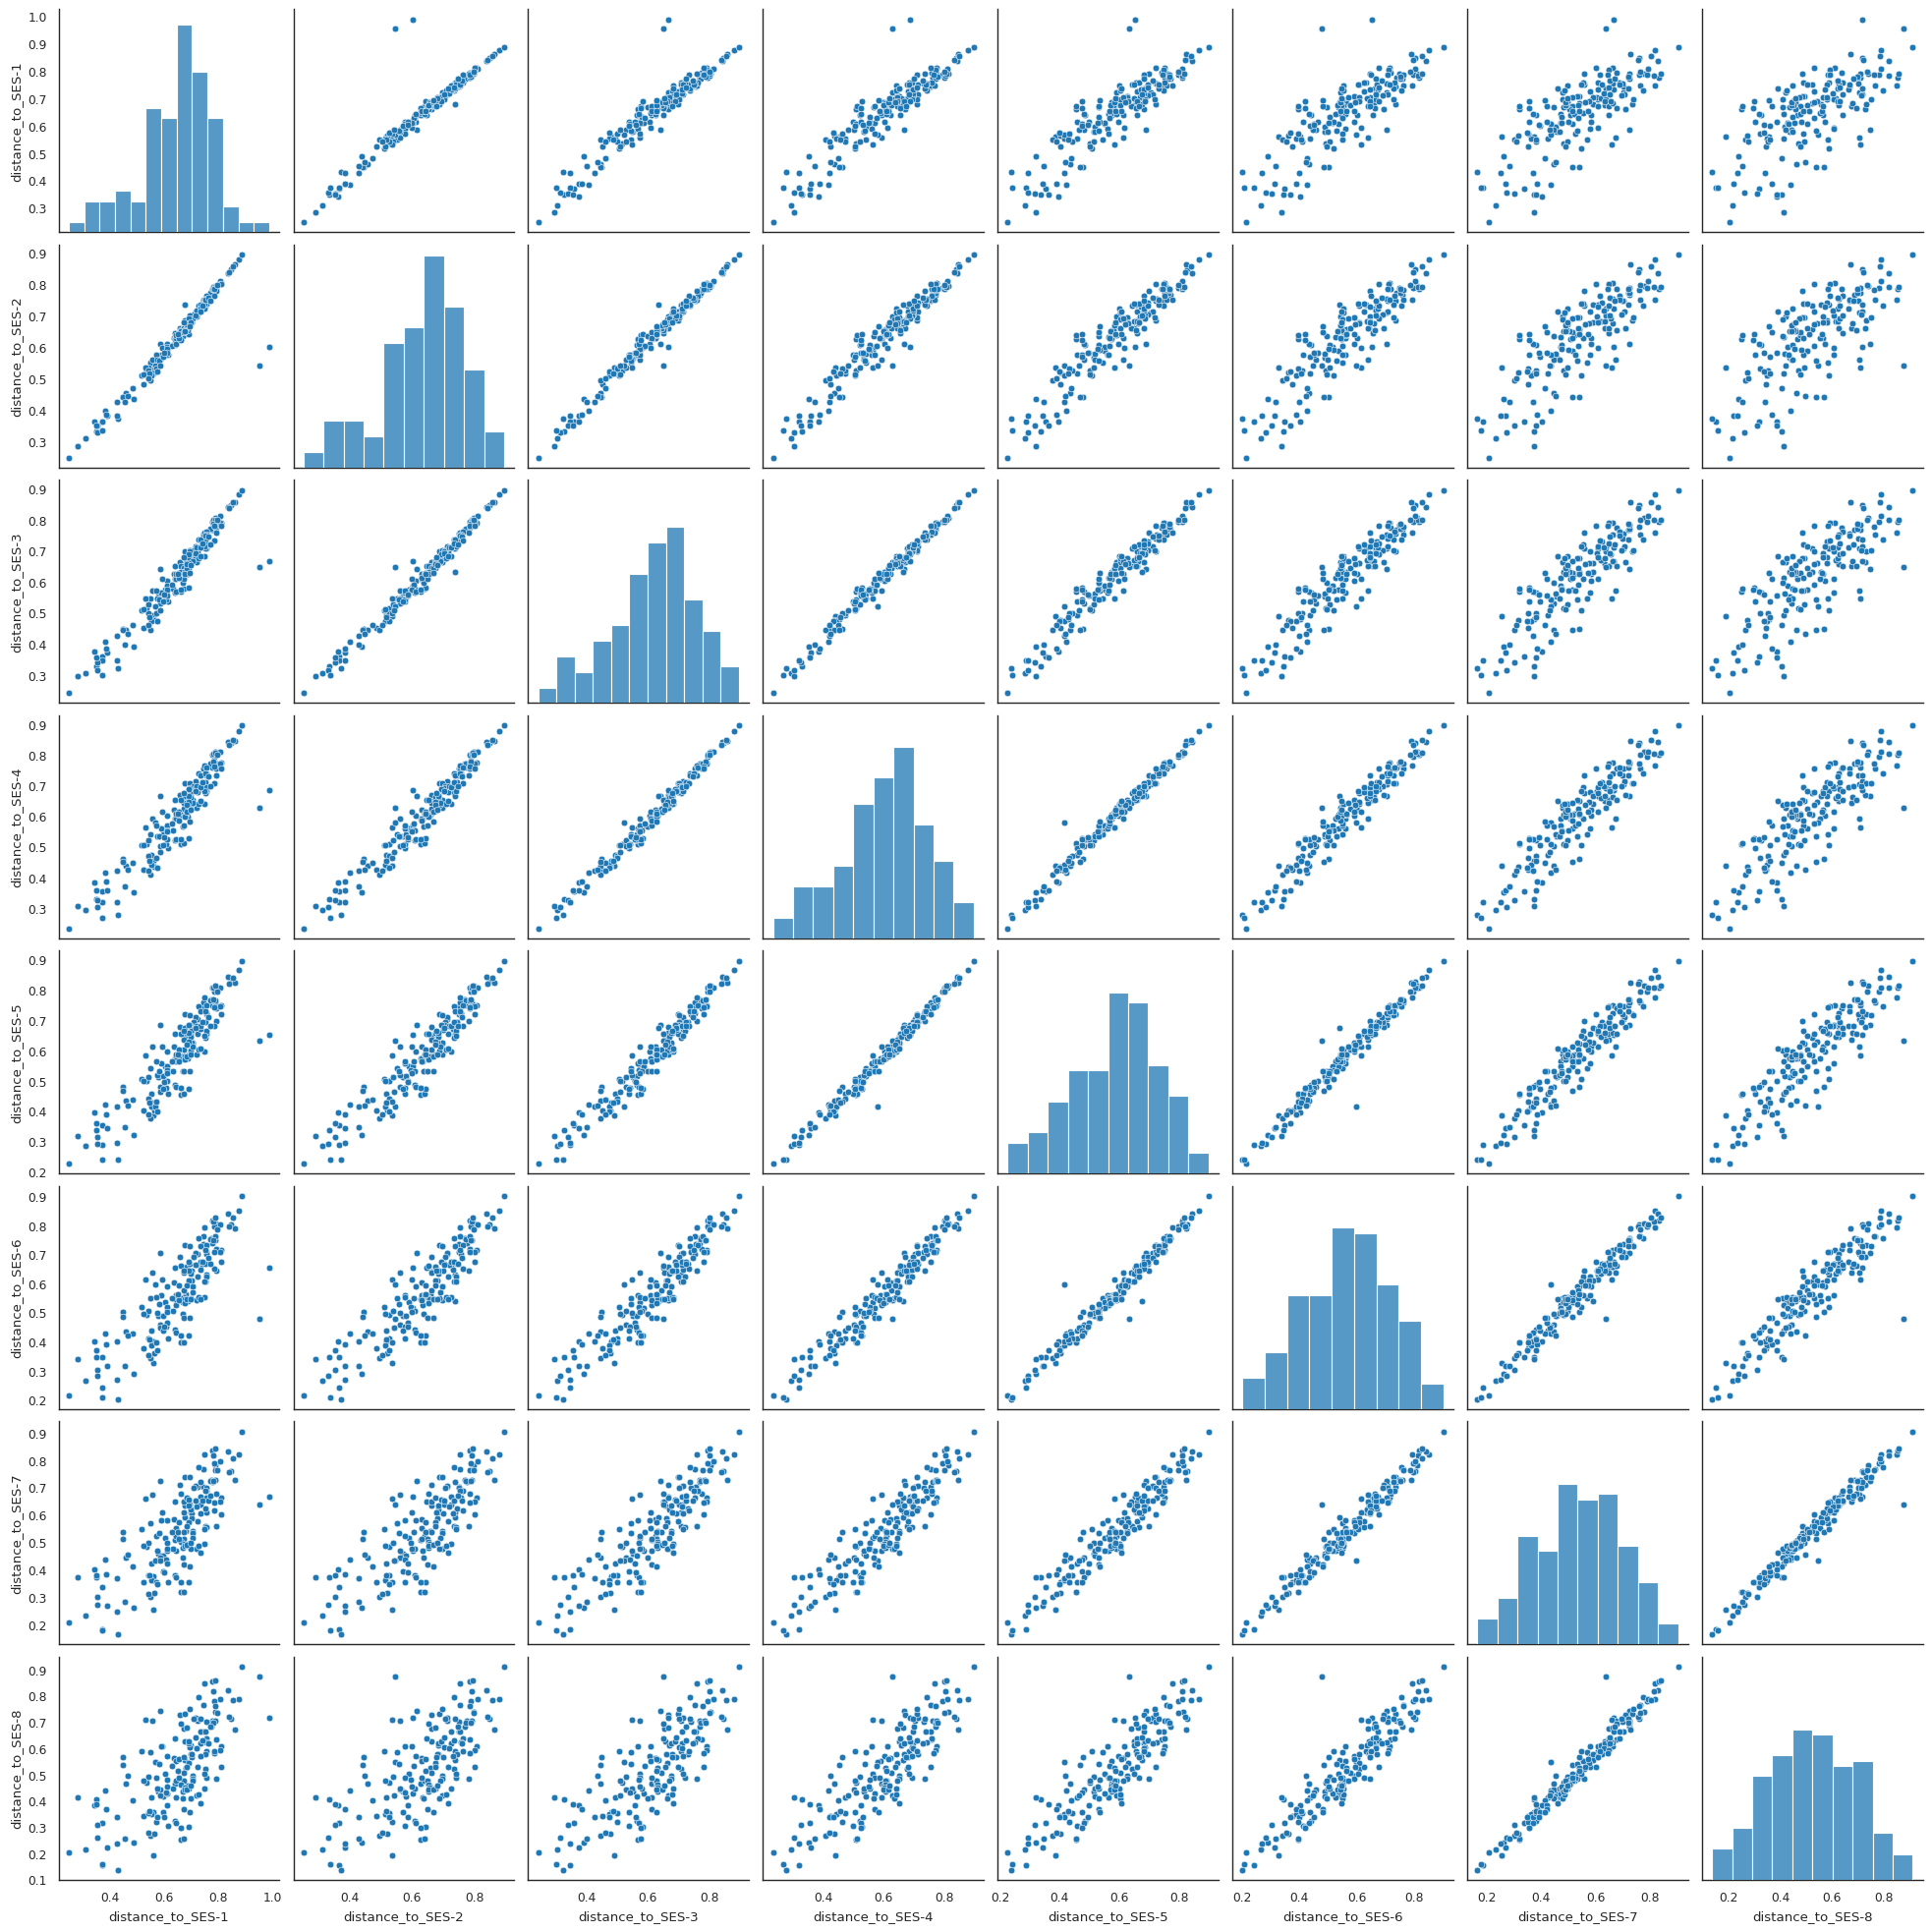

In [13]:
cols = [f'distance_to_SES-{i}' for i in range(1,9)]
sns.set_style("white")
sns.set_context("paper")
plt.figure(figsize=(10, 4))

sns.pairplot(data=gpt,vars=cols)

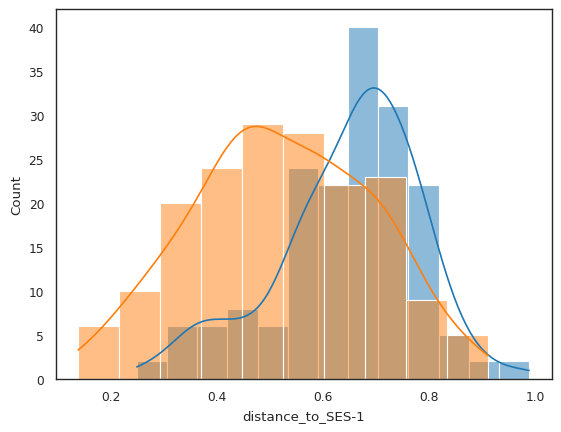

In [14]:
for col in ["distance_to_SES-1","distance_to_SES-8"]:
    sns.histplot(gpt[col],kde=True)
plt.show()

In [15]:
gpt[cols].values[:, np.newaxis].T.shape

(8, 1, 176)

In [16]:
gpt[cols].values.T.shape

(8, 176)

In [17]:
op = (gpt[cols].values[:, np.newaxis].T - gpt[cols].values.T).T

In [19]:
op = np.power(op,2)

In [40]:
gpt["most_distant_ses"] = np.argmax(np.mean(op,axis=1),axis=1)

/tmp/ipykernel_205/1354405006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpt["most_distant_ses"] = np.argmax(np.mean(op,axis=1),axis=1)
